# OFDM example using the OFDM_SDR_Functions_torch.py

OFDM_SDR_Functions_torch.py is a torch implementation of the functions made available in https://github.com/rikluost/ofdm-plutosdr-numpy. It provides all required functions to generate data stream, OFDM signal and reconstruction back to a data stream. The functions utilise PyTorch where possible, however, not all functions can be utilising PyTorch as the SDR software utisises NumPy in input and output. The intention is to allow easy use of AIML for PHY-processing.

SDR_Pluto handles the transmission and reception of the signal over the air and utilising PlutoSDR software defined radio for it. Alternatively CDL-C channel model can be used instead of the SDR.

This jupyter notebook shows an example on how to use the libraries.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import OFDM_SDR_Functions_torch
import SDR_Pluto
import config
import torch

# SDR Configuration
use_sdr = True # Set to `True` to use SDR for transmission and reception, or `False` to run the system in simulation mode.

SDR_TX_Frequency = int(435e6)  # SDR TX frequency in Hz
tx_gain = -20  # Transmission gain in dB for SDR
rx_gain = 20  # Reception gain in dB for SDR

# 3GPP CDL-C Channel Simulation Parameters in case no sdr
ch_SINR = 30  # SINR for channel emulation CDL-C

# OFDM Configuration is stored in config.py

## OFDM System Parameters

### SDR Configuration (Optional)

- `use_sdr` (`bool`): Set to `True` to use SDR for transmission and reception, or `False` to run the system in simulation mode.
- `SDR_TX_Frequency` (`int`): SDR Transmission Frequency
- `tx_gain` (`int`): Transmission gain for the SDR
- `rx_gain` (`int`): Reception gain for the SDR
- `tx_frequency` (`float`): Transmission frequency

### 3GPP CDL-C Channel Simulation

In case `use_sdr` is set to False:
- `ch_SINR` (`int`): Signal-to-Interference-plus-Noise Ratio (SINR) for the CDL-C channel emulation

### OFDM System Configuration

- `Qm` (`int`): Modulation order
- `F` (`int`): Number of subcarriers
- `S` (`int`): Number of symbols,=
- `FFT_size` (`int`): FFT size
- `Fp` (`int`): Pilot subcarrier spacing
- `Sp` (`int`): Pilot symbol spacing
- `CP` (`int`): Cyclic Prefix length
- `SCS` (`int`): Subcarrier spacing
- `P` (`int`): Number of pilot subcarriers
- `sn` (`int`): Serial number starting value
- `Qm_sn` (`int`): Serial number modulation order
- `FFT_offset` (`int`): FFT offset, calculated as (FFT size - Number of subcarriers)/2.
- `SampleRate` (`float`): Sample rate, calculated as FFT size * Subcarrier spacing.
- `Ts` (`float`): Sample duration, calculated as 1/(Subcarrier spacing * FFT size).
- `TTI_duration` (`float`): TTI duration in ms, calculated using the provided formula.
- `Pilot_Power` (`float`): Power allocated for the pilot signals
- `PDSCH_power` (`float`): Power allocated for the PDSCH

### SINR Measurement

- `leading_zeros` (`int`): Number of symbols with zero value used for SINR measurement

## Create modulation mapping tables

Modulation mapping tables translate binary data sequences into complex symbols for transmission in digital communication systems. BPSK, QPSK, and 16-QAM, e.g. 64QAM, 256QAM 1024 QAM and so on are possible. The higher the modulation order, the higher the SINR requirement.

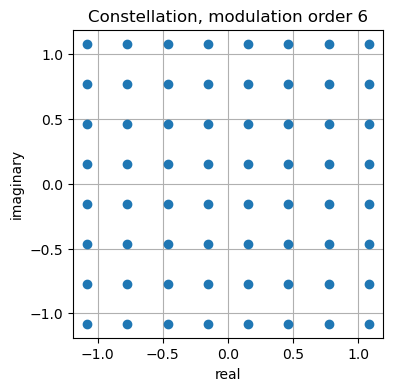

In [59]:
mapping_table_QPSK, de_mapping_table_QPSK = OFDM_SDR_Functions_torch.mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = OFDM_SDR_Functions_torch.mapping_table(config.Qm, plotMap=True) # mapping table for Qm

## Creating a TTI Mask with symbol allocations

A TTI mask represents the allocation of the complex symbols over a specific Transmission Time Interval (TTI). It is a matrix or a 2D array where the rows represent the time slots within a TTI, and the columns represent the available symbols in frequency domain. The values in the matrix indicate the use:

- `0`: The PRB is null power.
- `1`: The PRB is PDSCH.
- `2`: Pilot symbols

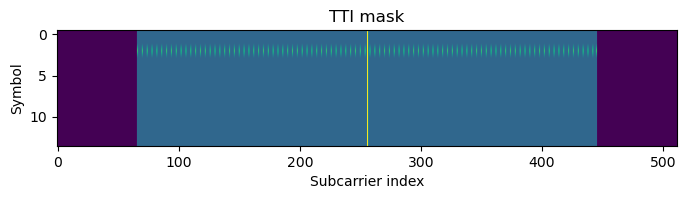

In [60]:
TTI_mask_RE = OFDM_SDR_Functions_torch.TTI_mask(S=config.S,F=config.F, Fp=config.Fp, Sp=config.Sp, FFT_offset=config.FFT_offset, plotTTI=True)

## Creating and Inserting Pilot Symbols in OFDM

Pilot symbols are crucial in OFDM systems for reliable data transmission, aiding in channel estimation, synchronization, and error correction at the receiver. They are predefined, known symbols placed at specific intervals across the OFDM frame. Their known properties help the receiver in demodulating and decoding the received signal accurately.

In [61]:
pilot_symbols = OFDM_SDR_Functions_torch.pilot_set(TTI_mask_RE, config.Pilot_Power)

## Start the SDR

**Initialize the PlutoSDR Transceiver**: Create a PlutoSDR object and configure it with the appropriate transmission parameters including RF bandwidth, carrier frequency, and hardware gain.


In [62]:
# start the SDR 
if use_sdr:
     SDR_1 = SDR_Pluto.SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=SDR_TX_Frequency, SDR_TX_GAIN=tx_gain, SDR_RX_GAIN = rx_gain, SDR_TX_SAMPLERATE=config.SampleRate, SDR_TX_BANDWIDTH=config.F*config.SCS*2)
     SDR_1.SDR_TX_start()
#     tx_gain = SDR_1.find_good_max_TX_gain_value(SDR_RX_GAIN=30, Max_SINR=35)

## Data stream creation OFDM Modulation, FFT, and Cyclic Prefix Addition

Here a single data stream is created, modulated, FFT is applied, and cyclic prefix is added.


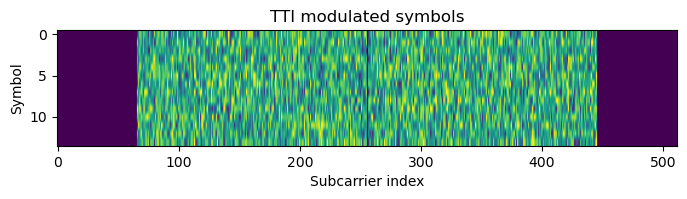

In [63]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols = OFDM_SDR_Functions_torch.create_PDSCH_data(TTI_mask_RE, config.Qm, mapping_table_Qm, power=config.PDSCH_power)
    Modulated_TTI = OFDM_SDR_Functions_torch.RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=True)
    TD_TTI_IQ = OFDM_SDR_Functions_torch.FFT(Modulated_TTI)
    TX_Samples = OFDM_SDR_Functions_torch.CP_addition(TD_TTI_IQ, config.S, config.FFT_size, config.CP)
    zeros = torch.zeros(config.leading_zeros, dtype=TX_Samples.dtype)

    # Concatenate the tensors
    TX_Samples = torch.cat((zeros, TX_Samples), dim=0)
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

## Radio Channel - Transmitting and Receiving OFDM Symbols with PlutoSDR or a simulated channel

In [64]:
print (de_mapping_table_Qm)

{tensor(-1.0801-1.0801j): (0, 0, 0, 0, 0, 0), tensor(-1.0801-0.7715j): (0, 0, 0, 0, 0, 1), tensor(-1.0801-0.4629j): (0, 0, 0, 0, 1, 0), tensor(-1.0801-0.1543j): (0, 0, 0, 0, 1, 1), tensor(-1.0801+0.1543j): (0, 0, 0, 1, 0, 0), tensor(-1.0801+0.4629j): (0, 0, 0, 1, 0, 1), tensor(-1.0801+0.7715j): (0, 0, 0, 1, 1, 0), tensor(-1.0801+1.0801j): (0, 0, 0, 1, 1, 1), tensor(-0.7715-1.0801j): (0, 0, 1, 0, 0, 0), tensor(-0.7715-0.7715j): (0, 0, 1, 0, 0, 1), tensor(-0.7715-0.4629j): (0, 0, 1, 0, 1, 0), tensor(-0.7715-0.1543j): (0, 0, 1, 0, 1, 1), tensor(-0.7715+0.1543j): (0, 0, 1, 1, 0, 0), tensor(-0.7715+0.4629j): (0, 0, 1, 1, 0, 1), tensor(-0.7715+0.7715j): (0, 0, 1, 1, 1, 0), tensor(-0.7715+1.0801j): (0, 0, 1, 1, 1, 1), tensor(-0.4629-1.0801j): (0, 1, 0, 0, 0, 0), tensor(-0.4629-0.7715j): (0, 1, 0, 0, 0, 1), tensor(-0.4629-0.4629j): (0, 1, 0, 0, 1, 0), tensor(-0.4629-0.1543j): (0, 1, 0, 0, 1, 1), tensor(-0.4629+0.1543j): (0, 1, 0, 1, 0, 0), tensor(-0.4629+0.4629j): (0, 1, 0, 1, 0, 1), tensor(-0

In [65]:
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        SDR_1.SDR_gain_set(tx_gain, rx_gain)
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=1, cyclic=True)
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4)
        SDR_1.SDR_TX_stop()
    else:
        rx_signal  = OFDM_SDR_Functions_torch.generate_cdl_c_impulse_response(tx_signal = tx_signal, num_samples=100, sampling_rate=config.SampleRate, SINR=ch_SINR, repeats = 4, random_start=True)
    return rx_signal

RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain, rx_gain = rx_gain, ch_SINR=ch_SINR)

### Power Spectral Densities of transmitted and received signals

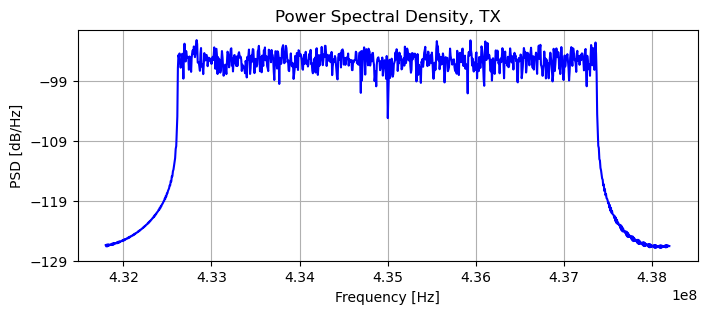

In [66]:
OFDM_SDR_Functions_torch.PSD_plot(TX_Samples, config.SampleRate, SDR_TX_Frequency, 'TX')

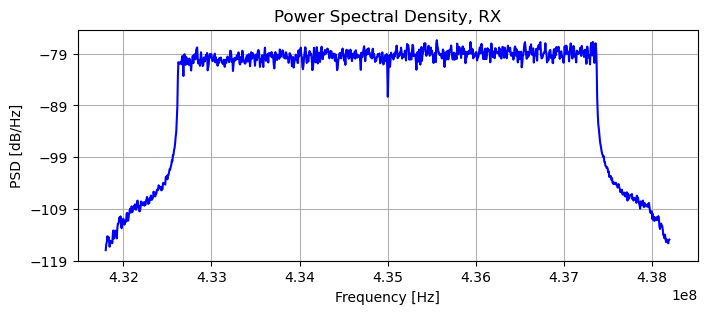

In [67]:
OFDM_SDR_Functions_torch.PSD_plot(RX_Samples, config.SampleRate, SDR_TX_Frequency, 'RX')

## Synchronization with Correlation for TTI Detection

Synchronization is achieved through correlation, which helps in finding the beginning of a Transmission Time Interval (TTI).


In [68]:
symbol_index=OFDM_SDR_Functions_torch.sync_TTI(TX_Samples, RX_Samples, config.leading_zeros)

## SINR calculation

Null symbols were added into the beginning of each transmission to allow measuring the noise level at the receiver. The average power of transmitted symbols is divided by the average power of those null symbols. Note that this gives only a rough estimate, as in this simple implementation the null symbols outside the transmit bandwidth are included in transmitted power calculation.

$\text{SINR} = \frac{\text{Signal Power}}{\text{Interference Power} + \text{Noise Power}}$


In [69]:
SINR = OFDM_SDR_Functions_torch.SINR(RX_Samples, 100, symbol_index)

## Cyclic Prefix Removal

The cyclic prefix (CP) is a crucial component in OFDM systems, added to each symbol to mitigate inter-symbol interference caused by multipath propagation. However, once the signal is received, the CP must be removed to proceed with demodulation and data recovery.

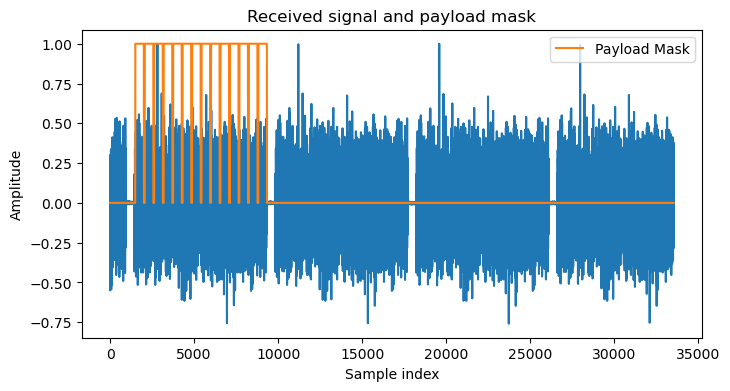

In [70]:
RX_NO_CP = OFDM_SDR_Functions_torch.CP_removal(RX_Samples, symbol_index, config.S, config.FFT_size, config.CP, plotsig=True)
RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP))

## Convert the the time domain OFDM signal into frequency domain

Fast Fourier Transform (FFT) transforms the received time-domain signal back into the frequency domain, where data on individual subcarriers can be independently demodulated.


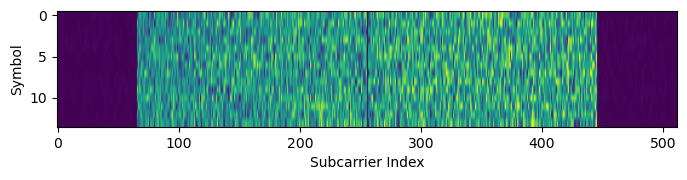

In [71]:
OFDM_demod = OFDM_SDR_Functions_torch.DFT(RX_NO_CP, plotDFT=True)

## Channel Estimation

Channel estimation aims to characterize the channel's effect on the transmitted signal, which is essential for accurate data demodulation and improving system performance. 

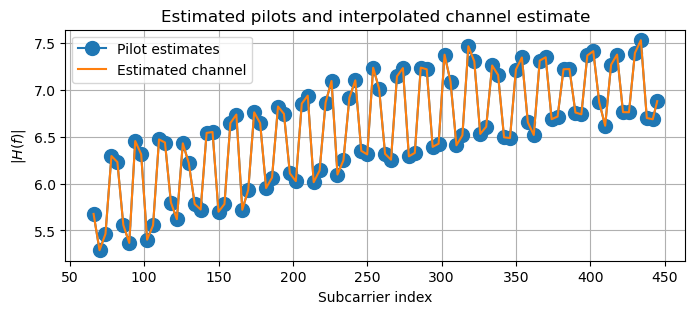

In [72]:
H_estim = OFDM_SDR_Functions_torch.channelEstimate_LS(TTI_mask_RE, pilot_symbols, config.F, config.FFT_offset, config.Sp, OFDM_demod, plotEst=True)

## Equalization in OFDM Systems

Equalization aims to mitigate the phase and amplitude variations introduced by the communication channel, ensuring accurate data recovery.

In [73]:
OFDM_demod_no_offsets = OFDM_SDR_Functions_torch.remove_fft_Offests(OFDM_demod, config.F, config.FFT_offset)
equalized_H_estim = OFDM_SDR_Functions_torch.equalize_ZF(OFDM_demod_no_offsets, H_estim, config.F, config.S)

## Payload Symbols extraction

The payload in an OFDM system refers to the actual data transmitted, excluding overheads like cyclic prefixes, pilot symbols, and any additional signaling or control information. 

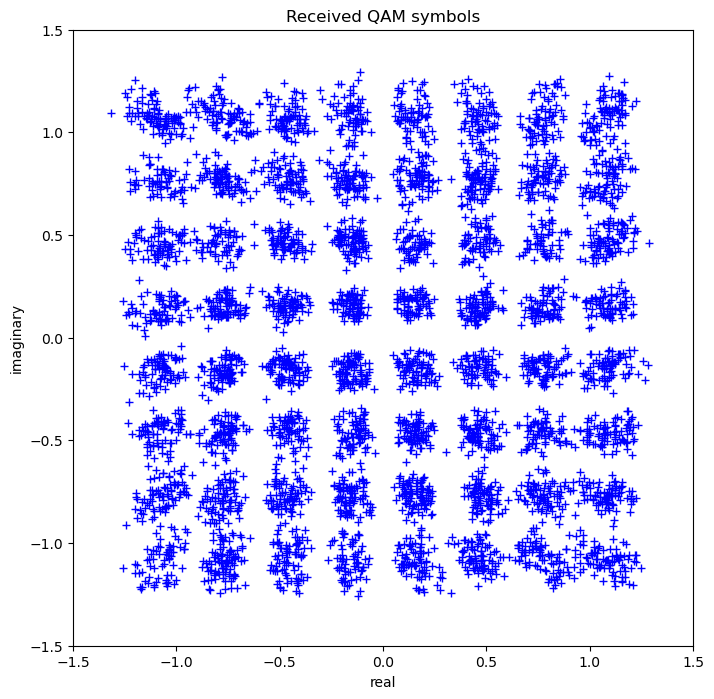

In [74]:

QAM_est = OFDM_SDR_Functions_torch.get_payload_symbols(TTI_mask_RE, equalized_H_estim, config.FFT_offset, config.F, plotQAM=True)

## Converting OFDM Symbols to Data

After receiving and processing the OFDM symbols, the final step is to convert them back into the original data stream. This process involves demodulation, demapping and combining the information to data stream.

In [75]:
PS_est, hardDecision = OFDM_SDR_Functions_torch.Demapping(QAM_est, de_mapping_table_Qm)
bits_est = OFDM_SDR_Functions_torch.PS(PS_est)

## Calculating Bit Error Rate (BER) 

Understanding the performance of an OFDM system requires evaluating key metrics like Bit Error Rate (BER) and Signal-to-Interference-plus-Noise Ratio (SINR). The received data bits are compared to the original transmitted bits to identify errors.

$\text{BER} = \frac{\text{Number of Bit Errors}}{\text{Total Number of Transmitted Bits}}$


In [76]:
error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
error_rate = error_count / bits_est.numel()  # Error rate calculation
BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

SINR = OFDM_SDR_Functions_torch.SINR(RX_Samples, 100, symbol_index)
print(f"BER: {BER}, SINR: {SINR}dB")


BER: 0.017999999225139618, SINR: 34.0dB
